<a href="https://colab.research.google.com/github/mrkevinlin/MLmed/blob/master/METS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:
#**- Determine imputation to use**

# **Initialize everything**

In [0]:
!pip install --upgrade -q gspread

from __future__ import print_function

import math
from google.colab import files
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
from keras.wrappers.scikit_learn import KerasRegressor

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 15
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Create a DataFrame of patient data

**Import CSV to populate a DataFrame**

In [0]:
# Open Google Sheet of patient data and get column titles
patient_dataframe = gc.open('patient_data').sheet1
column_names = patient_dataframe.row_values(1)

# Process Google Sheet into a pandas dataframe of all numeric values
patient_dataframe = pd.DataFrame.from_records(
    patient_dataframe.get_all_values(),
    columns=column_names)
patient_dataframe = patient_dataframe.iloc[1:]
patient_dataframe = patient_dataframe.apply(pd.to_numeric, errors='coerce')
patient_dataframe = patient_dataframe.replace('', np.nan)
patient_dataframe_original = patient_dataframe.copy()
patient_dataframe_stats = patient_dataframe_original.copy()

# **Create methods for cleaning up data**

In [0]:
def process_data(df):
  # Try alternate features and targets
  trial = 2
  
  # Specify features and labels to work with
  if trial==1: # Predict improvement in 6MWT distance after CR
    target_label = 'delta_6mwt'
    numeric_selected_features = ['entry_knowledge', 'entry_height', 'entry_weight', 'entry_waist', 'entry_BF', 'entry_BMI', 'entry_met']
    optional_numeric_selected_features = ['entry_chol', 'entry_trig', 'entry_hdl', 'entry_ldl']
    categorical_selected_features = ['normal_a', 'borderline_a', 'abnormal_a', 'normal_d', 'borderline_d', 'abnormal_d']
    
    df = create_synthetic_target(df, target_label)
    
  elif trial==2: # Predict initial exercise tolerance with entry MET
    target_label = 'entry_met'
    numeric_selected_features = ['entry_knowledge', 'entry_height', 'entry_weight', 'entry_waist', 'entry_BF', 'entry_BMI', 'entry_6mwt']
    optional_numeric_selected_features = ['entry_chol', 'entry_trig', 'entry_hdl', 'entry_ldl']
    categorical_selected_features = ['normal_a', 'borderline_a', 'abnormal_a', 'normal_d', 'borderline_d', 'abnormal_d']
      
  else:
    return
  
  df = create_features(df)
  df = clean_up_by_target(df, target_label)
  df = remove_outliers(df, 'entry_trig', 1000)
  df = remove_outliers(df, 'entry_6mwt', 2000)
  df = median_impute_missing_values(df) # Temporary  
  df[numeric_selected_features] = scale_features_z_score(df[numeric_selected_features].copy())
  
  # Split into used feature and label dataframes
  feature_df = df[numeric_selected_features+categorical_selected_features]
  target_df = df[target_label]
  
  return feature_df, target_df

# Create synthetic features
def create_features(df):
  df = calculate_bmi(df)
  df = create_hads_bins(df)
  return df

# Create target label of change in 6MWT results  
def create_synthetic_target(df, target):
  df[target] = (df['exit_6mwt'] - df['entry_6mwt'])
  return df
  
# Create categorical bins of anxiety and depression scale
def create_hads_bins(df):
  hads_bins=[-1,7,10,21]
  anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['normal_a', 'borderline_a', 'abnormal_a']))
  depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['normal_d', 'borderline_d', 'abnormal_d']))
  return df.join(anxiety_df).join(depression_df) 
  
# Recalculate and fill in BMI from height/weight
def calculate_bmi(df):
  df['calc_bmi'] = (702.95 * df['entry_weight']/(df['entry_height'] ** 2))
  return df

# Remove all rows with values missing in the specified columns
def clean_up_by_target(df, column):
  return df.dropna(subset=[column])

# Remove flagrant outliers by clipping
def remove_outliers(df, feature, maximum):
  df[feature] = df[feature].clip(lower=0, upper=maximum)
  return df

# Replace missing values with the median of the group (temporary measure)
def median_impute_missing_values(df):
  for col in df.columns:
    if df[col].isnull().values.any():
      df[col] = df[col].fillna(df[col].median())
  return df

# Normalize the values of features
def scale_features_z_score(df):
  for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()
  return df


# **View some stats on the original data**

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,...,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl,entry_normal_a,entry_borderline_a,entry_abnormal_a,entry_normal_d,entry_borderline_d,entry_abnormal_d,exit_normal_a,exit_borderline_a,exit_abnormal_a,exit_normal_d,exit_borderline_d,exit_abnormal_d,calc_bmi
count,566.000,478.000,487.000,411.000,441.000,523.000,506.000,491.000,407.000,376.000,487.000,330.000,330.000,328.000,323.000,118.000,121.000,88.000,123.000,123.000,...,86.000,80.000,124.000,97.000,97.000,98.000,98.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,440.000
mean,2016.756,67.383,5.072,5.088,66.714,192.452,39.385,29.948,30.313,1083.535,2.551,159.458,135.733,47.384,88.077,73.924,3.479,2.682,187.728,38.219,...,29.002,1493.312,3.263,150.948,107.546,54.112,76.755,0.641,0.118,0.101,0.542,0.097,0.087,0.186,0.023,0.005,0.143,0.009,0.004,30.260
std,1.149,20.886,4.413,4.316,4.378,47.627,5.889,8.189,6.552,392.374,0.513,47.339,130.403,15.538,37.438,19.176,3.349,3.124,43.234,5.480,...,5.250,351.040,0.682,41.186,59.681,17.704,30.487,0.480,0.323,0.301,0.499,0.296,0.281,0.389,0.150,0.073,0.350,0.094,0.059,6.857
min,2015.000,0.000,0.000,0.000,54.250,90.600,24.000,9.000,17.000,200.000,1.100,51.000,33.000,11.000,7.000,15.000,0.000,0.000,121.600,27.250,...,19.310,300.000,1.400,69.000,43.000,31.000,24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.023
25%,2016.000,54.000,1.000,2.000,63.750,159.150,35.500,23.705,25.120,900.000,2.300,127.250,76.000,36.000,61.000,62.000,0.000,0.000,156.800,34.750,...,24.150,1361.250,2.900,124.000,72.000,41.000,54.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25.054
50%,2017.000,69.000,4.000,4.000,66.800,184.500,38.750,29.500,29.100,1100.000,2.600,152.000,107.000,45.000,84.000,77.000,3.000,2.000,182.400,37.500,...,28.300,1525.000,3.200,144.000,94.000,50.000,72.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,29.088
75%,2018.000,85.000,8.000,8.000,70.000,218.200,43.000,36.000,34.375,1276.000,2.900,184.750,153.000,56.000,106.500,92.000,6.000,4.000,209.500,41.250,...,33.147,1701.000,3.625,167.000,121.000,61.750,92.500,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,34.378
max,2019.000,100.000,21.000,21.000,79.000,399.200,64.500,50.000,62.300,5422.000,6.500,342.000,1549.000,100.000,245.000,100.000,13.000,14.000,299.600,64.000,...,40.720,2189.000,6.200,289.000,389.000,118.000,169.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,64.512



Number missing in each column:


year                   0
entry_knowledge       88
entry_hads_a          79
entry_hads_d         155
entry_height         125
entry_weight          43
entry_waist           60
                    ... 
exit_normal_a          0
exit_borderline_a      0
exit_abnormal_a        0
exit_normal_d          0
exit_borderline_d      0
exit_abnormal_d        0
calc_bmi             126
Length: 41, dtype: int64

entry normal (a) count: 363
entry borderline (a) count: 67
entry abnormal (a) count: 57
entry normal (d) count: 307
entry borderline (d) count: 55
entry abnormal (d) count: 49
exit normal (a) count: 105
exit borderline (a) count: 13
exit abnormal (a) count: 3
exit normal (d) count: 81
exit borderline (d) count: 5
exit abnormal (d) count: 2


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


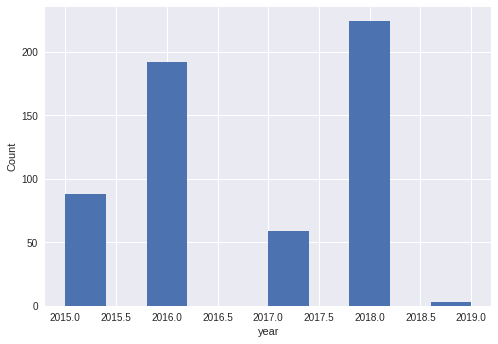

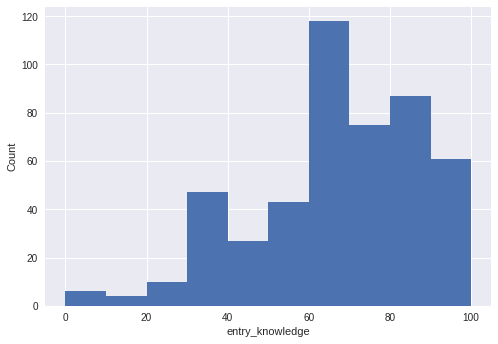

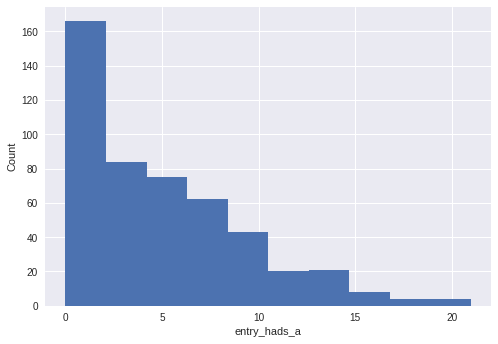

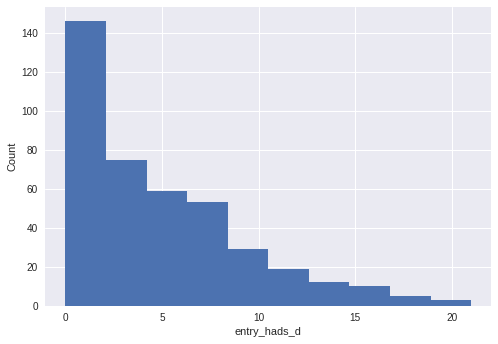

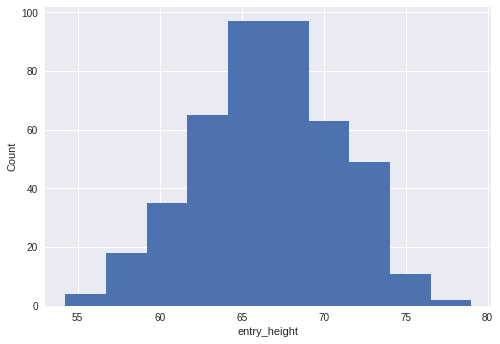

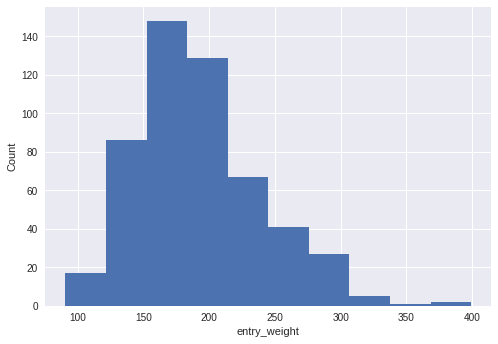

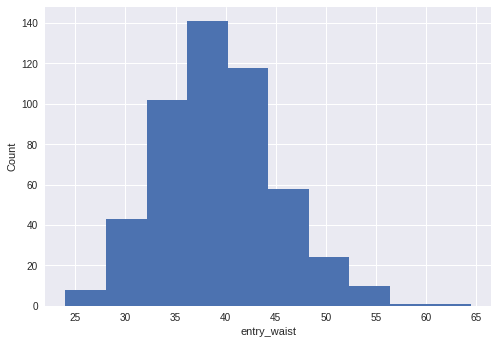

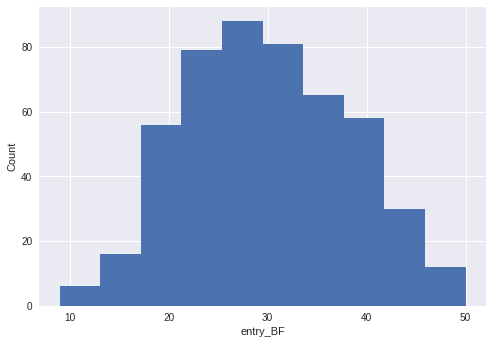

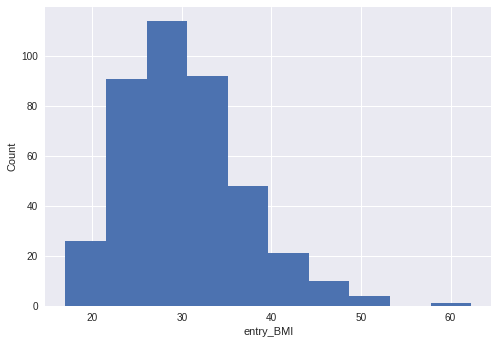

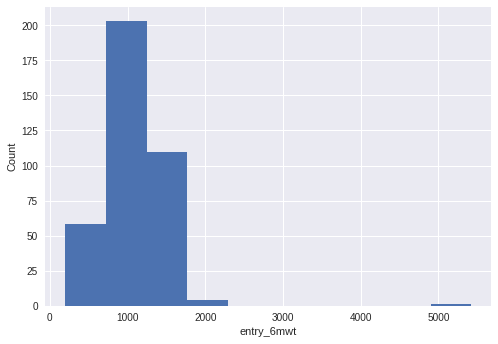

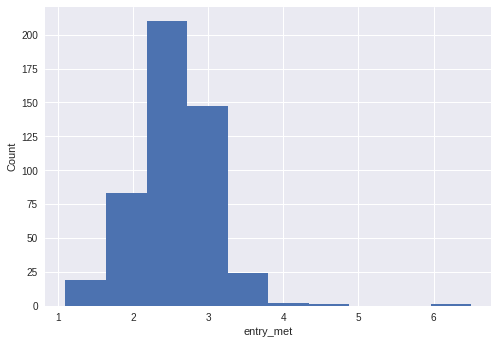

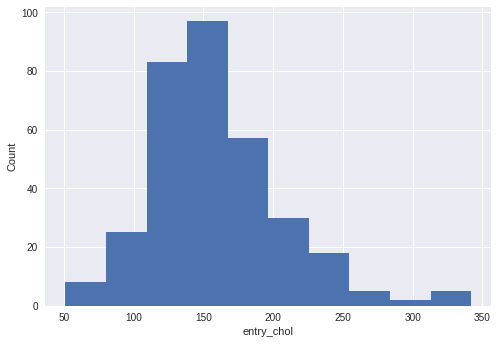

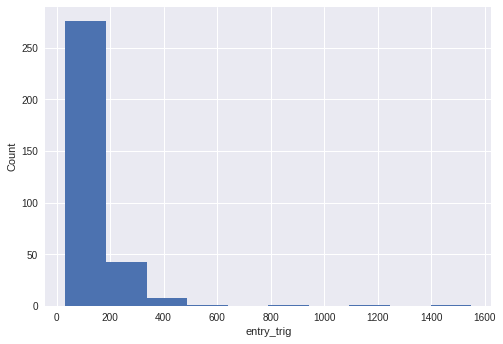

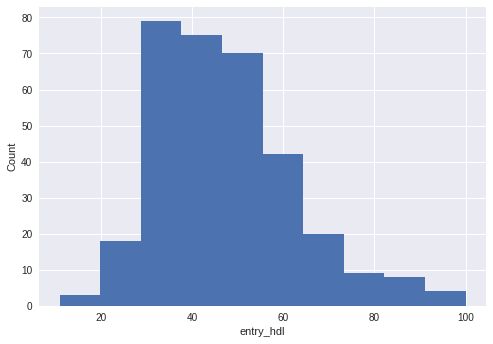

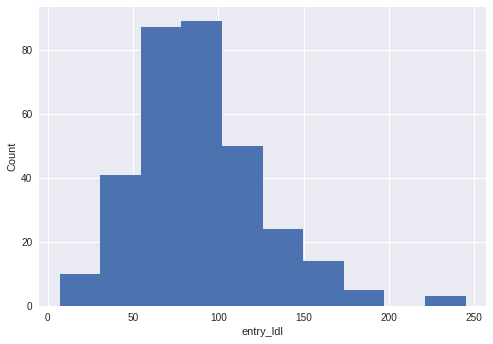

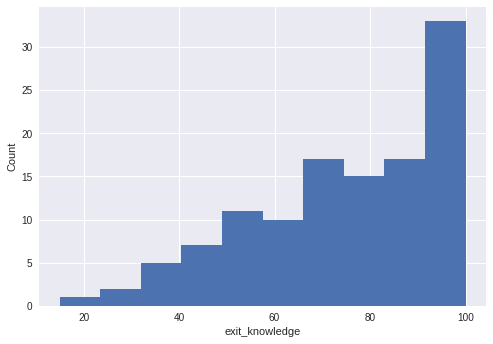

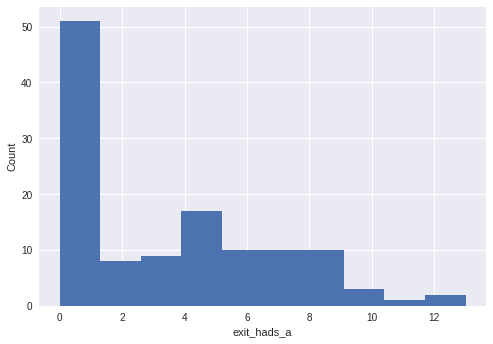

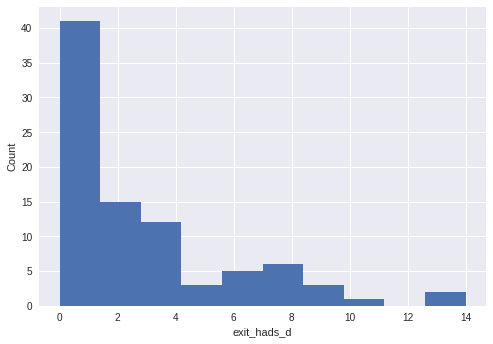

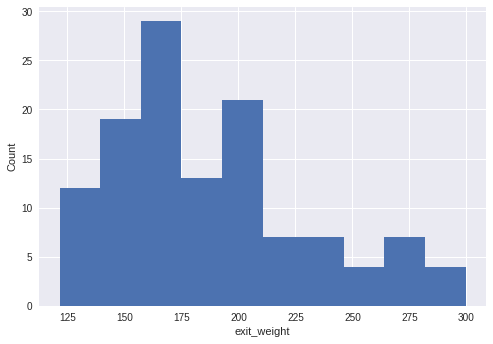

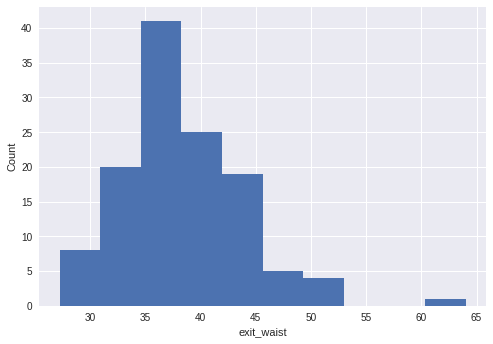

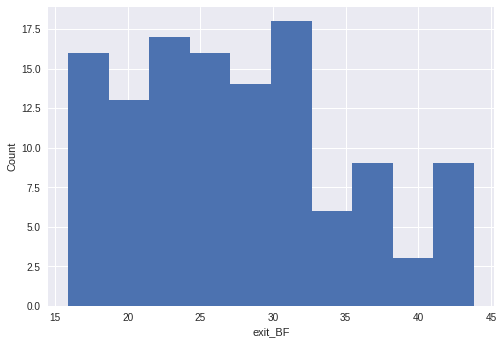

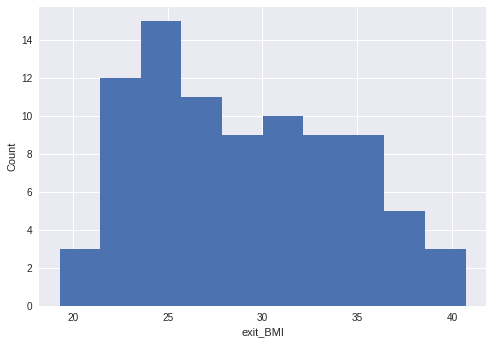

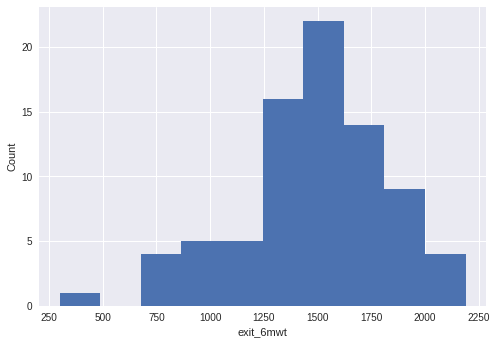

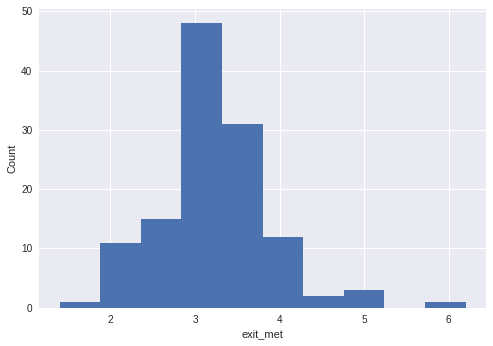

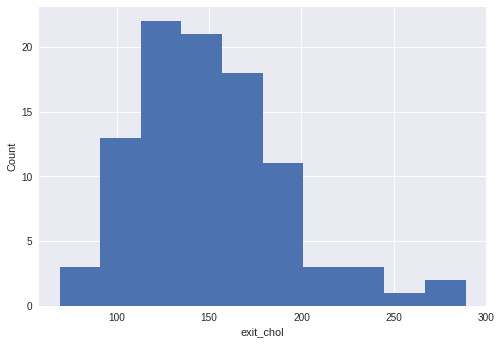

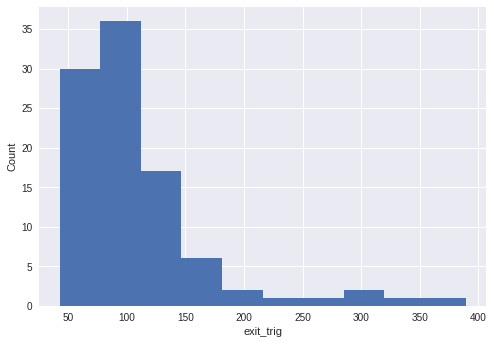

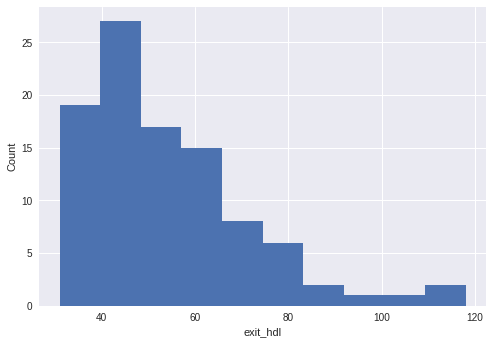

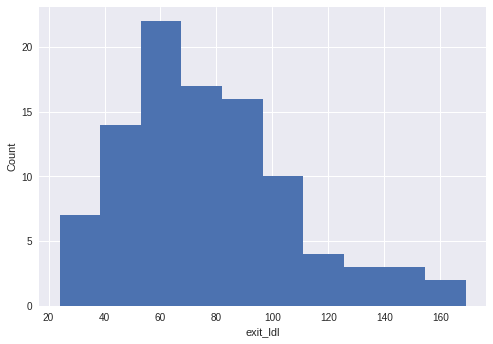

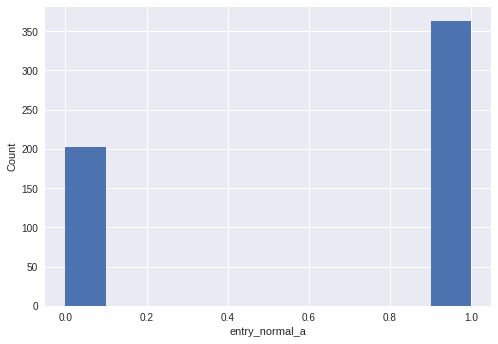

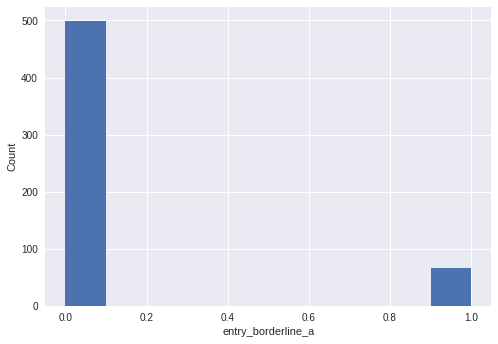

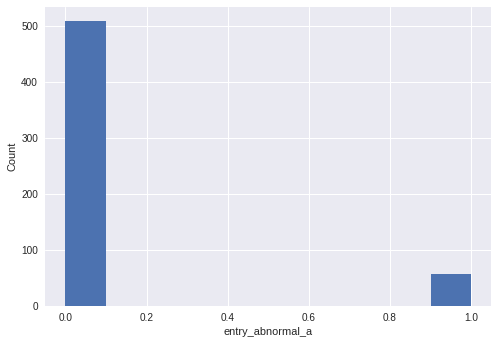

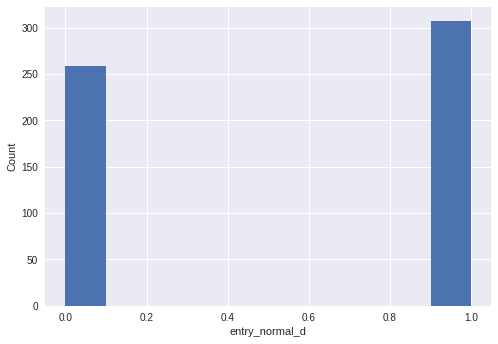

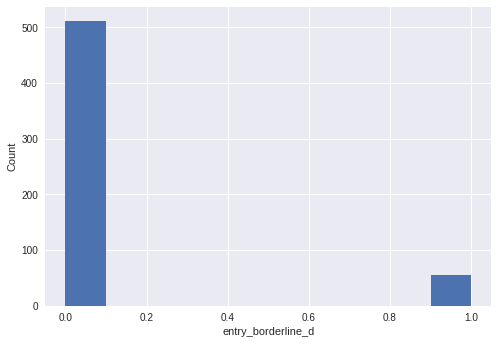

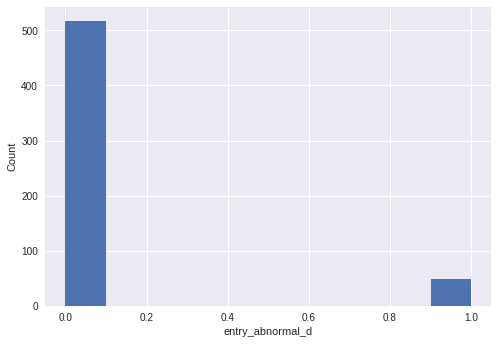

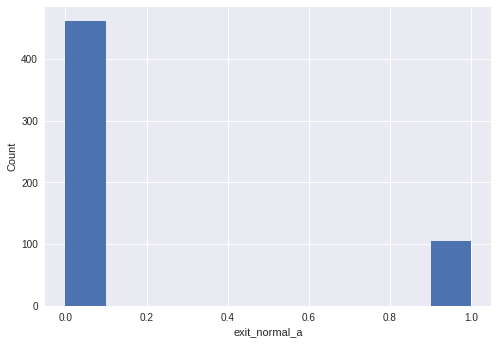

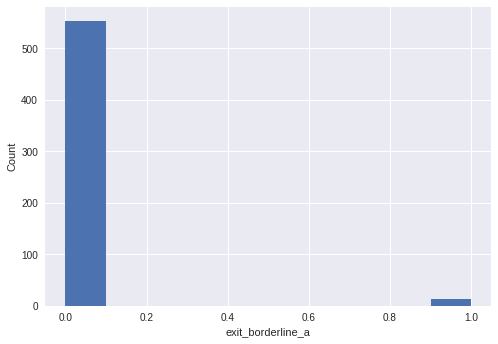

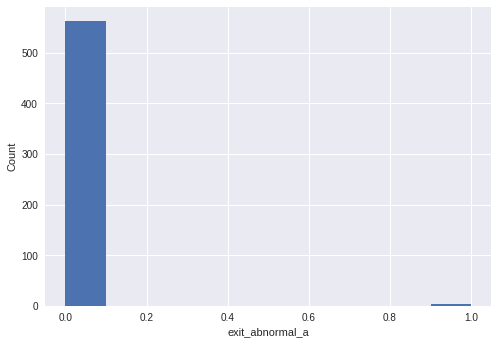

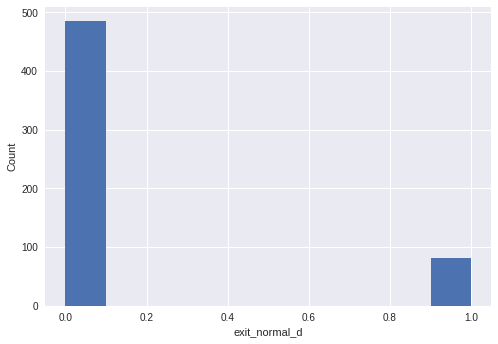

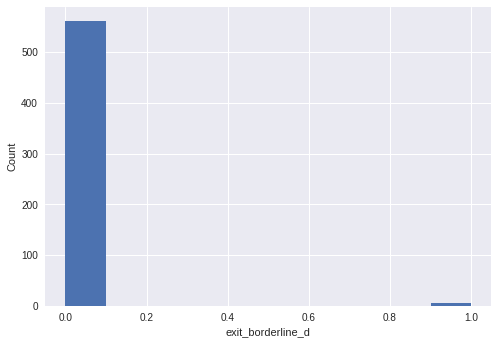

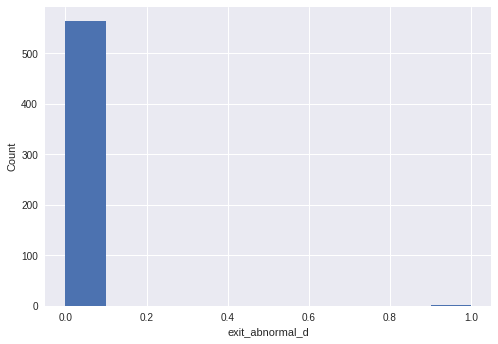

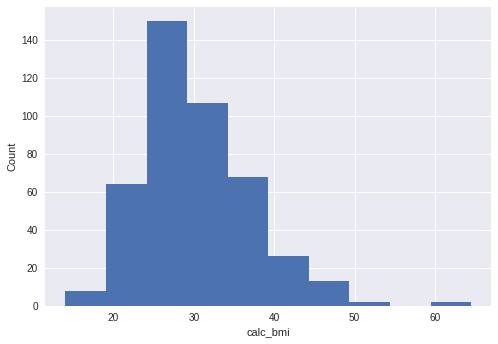

In [11]:
def view_stats(df):
  
  df = create_all_hads_bins(df)
  df = calculate_bmi(df) 

  plt.close('all')
  display.display(df.describe())
  print("\nNumber missing in each column:")
  display.display(df.isna().sum())
  
  hads_columns = ['normal', 'borderline', 'abnormal']
  for timing in ['entry', 'exit']:
    for mood in ['a', 'd']:
      for col in hads_columns:
        print('%s %s (%s) count: ' % (timing, col, mood) + str(df['%s_%s_%s' % (timing, col, mood)].sum()))
        

  plt.close('all')
  for col in df.columns:
    plt.figure()
    plt.hist(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")

    
def create_all_hads_bins(df):
  hads_bins=[-1,7,10,21]
  entry_anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['entry_normal_a', 'entry_borderline_a', 'entry_abnormal_a']))
  entry_depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['entry_normal_d', 'entry_borderline_d', 'entry_abnormal_d']))
  exit_anxiety_df = pd.get_dummies(pd.cut(df['exit_hads_a'], bins=hads_bins, labels=['exit_normal_a', 'exit_borderline_a', 'exit_abnormal_a']))
  exit_depression_df = pd.get_dummies(pd.cut(df['exit_hads_d'], bins=hads_bins, labels=['exit_normal_d', 'exit_borderline_d', 'exit_abnormal_d']))
  return df.join(entry_anxiety_df).join(entry_depression_df).join(exit_anxiety_df).join(exit_depression_df)

view_stats(patient_dataframe_stats)

# **Split into training and test sets**

In [0]:
# Close the matlib plots from view stats to reduce memory usage
plt.close('all')
# Reset the dataframe
patient_dataframe = patient_dataframe_original.copy()

# Set random number seed
rand_state = 4

# Randomize and divide the data set into training and test sets
train_dataframe = patient_dataframe.sample(frac=0.8, random_state=rand_state)
test_dataframe = patient_dataframe.drop(train_dataframe.index)

#test_dataframe.describe()

# **View some stats on the training and test data**

In [23]:
feature_dataframe, target_dataframe = process_data(train_dataframe)
display.display(feature_dataframe.describe())
display.display(target_dataframe.describe())

,entry_knowledge,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,normal_a,borderline_a,abnormal_a,normal_d,borderline_d,abnormal_d
count,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000
mean,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.722,0.116,0.114,0.600,0.106,0.099
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.449,0.321,0.318,0.491,0.309,0.299
min,-3.421,-3.088,-2.097,-2.586,-2.515,-2.151,-3.060,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.709,-0.397,-0.701,-0.667,-0.754,-0.600,-0.427,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.044,-0.022,-0.164,-0.084,-0.084,-0.154,0.065,1.000,0.000,0.000,1.000,0.000,0.000
75%,0.848,0.604,0.551,0.584,0.719,0.506,0.527,1.000,0.000,0.000,1.000,0.000,0.000
max,1.601,3.106,4.189,4.170,2.512,5.278,3.342,1.000,1.000,1.000,1.000,1.000,1.000


count   395.000
mean      2.543
std       0.477
min       1.100
25%       2.300
50%       2.600
75%       2.900
max       4.400
Name: entry_met, dtype: float64

# **Set up Keras TensorFlow code**

**Set up functions to build and train models**

https://weina.me/nested-cross-validation/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764

In [0]:
# Create a model with various hyperparameters default
def build_model(learn_rate=0.001, neurons=64, dropout_rate=0.0):
  model = keras.Sequential([
      layers.Dense(neurons, activation=tf.nn.relu, input_shape=[len(feature_dataframe.columns)]),
      layers.Dropout(dropout_rate),
      layers.Dense(neurons, activation=tf.nn.relu),
      layers.Dropout(dropout_rate),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, epochs=500):
  hist = model.fit(
      x = x_train, 
      y = y_train,
      epochs = epochs,
      verbose=1,
      callbacks = [early_stop_call],
      validation_data = (x_test, y_test))
  return hist
  
# Callback function to stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

**Create nested cross-validation for optimal hyperparameter search and model performance estimation**

In [7]:
outer_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)
inner_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)

outer_scores = []
inner_scores = []
best_params = []

learn_rate = [0.001, 0.01, 0.1]#, 0.1, 0.25, 0.5]
dropout_rate = [0.0, 0.5, 0.8]#, 0.2, 0.4, 0.6, 0.8]
neurons = [16, 64]#[1, 4, 16, 64]
parameters = dict(learn_rate=learn_rate,
                  dropout_rate=dropout_rate,
                  #neurons=neurons
                 )

inner_model = None
inner_model = KerasRegressor(build_fn=build_model, epochs=500, verbose=0)
grid_estimator = GridSearchCV(estimator=inner_model, param_grid=parameters, scoring='neg_mean_squared_error', cv=inner_fold, verbose=2, iid=False)
#outer_scores = cross_val_score(grid, X=feature_dataframe, y=target_dataframe, scoring='neg_mean_squared_error', cv=outer_fold, verbose=0)

for i, (outer_train_index, outer_test_index) in enumerate(outer_fold.split(train_dataframe)):
  print("Begin fold " + str(i+1))
  
  outer_x_train, outer_y_train = process_data(train_dataframe.iloc[outer_train_index].copy())
  outer_x_test, outer_y_test = process_data(train_dataframe.iloc[outer_test_index].copy())
  
  grid_estimator.fit(outer_x_train, outer_y_train)
  inner_scores.append(grid_estimator.score(outer_x_test, outer_y_test))
  best_params.append(grid_estimator.best_params_)
  print(inner_scores)
  print(best_params)
  
outer_scores.append(sum(inner_scores)/len(inner_scores))
print("Overall score: " + str(outer_scores))
print(outer_scores)

Begin fold 1
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  20.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  17.3s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  16.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  16.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  17.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.1s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.6s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 17.8min finished


[-0.048432573194979976]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  32.8s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.6s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  35.1s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  32.6s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  35.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  37.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 31.6min finished


[-0.048432573194979976, -0.07354103377797906]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  54.0s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.0s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  49.5s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  49.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  51.6s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  53.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  53.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  57.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  53.8s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.1min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 4
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.2min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.2min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.4min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 67.2min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 5
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.9min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 91.4min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761, -0.08041845871422845]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]


AttributeError: ignored

In [30]:
# Copying over output from previous cell because running takes too long
inner_scores = [-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761, -0.08041845871422845]
best_params = [{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
outer_scores = []

print(inner_scores)
print(best_params)
outer_scores.append(sum(inner_scores)/len(inner_scores))
print(str(outer_scores))

[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761, -0.08041845871422845]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
[-0.0862235104572359]


# **Old, working standalone cross validation**

In [0]:
def build_model(train_df):
  model = keras.Sequential([
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu, input_shape=[len(train_df.columns)]),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, early_stop):
  if(early_stop):
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        verbose=1,
        callbacks = [early_stop_call],
        validation_data = (x_test, y_test)
    )
  else:
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        validation_data = (x_test, y_test)
    )
  return hist
  
# Stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
end_fold_error = pd.DataFrame(columns=['loss', 'MAE', 'MSE', 'test_loss', 'test_MAE', 'test_MSE'])
  
# Create cross validator
kf = KFold(n_splits=10, shuffle=True, random_state=4)

# Loop through the k folds for cross validation
for i, (train_index, test_index) in enumerate(kf.split(train_dataframe), 1):
  print("Training on fold " + str(i))
  
  #feature_train, feature_test = feature_data.iloc[train_index].copy(), feature_data.iloc[test_index].copy()
  #label_train, label_test = label_data.iloc[train_index], label_data.iloc[test_index]
  
  feature_train, label_train = process_data(train_dataframe.iloc[train_index].copy())
  feature_test, label_test = process_data(train_dataframe.iloc[test_index].copy())
  
  model = None
  model = build_model(feature_train)
  
  history = train_model(model, feature_train, label_train, feature_test, label_test, early_stop=True)
  mse_history = history.history['mean_squared_error']
  val_mse_history = history.history['val_mean_squared_error']
  end_fold_error = end_fold_error.append(
      pd.Series([history.history['loss'][-1],
                 history.history['mean_absolute_error'][-1],
                 mse_history[-1], 
                 history.history['val_loss'][-1],
                 history.history['val_mean_absolute_error'][-1],
                 val_mse_history[-1]], 
                index=end_fold_error.columns), ignore_index=True)
  print("Last training error: " + str(mse_history[-1]))
  print("Last validation error: " + str(val_mse_history[-1]))

# **Generate final model with optimal hyperparameters and evaluate performance**

In [39]:
final_model = build_model(learn_rate=0.001, dropout_rate=0.5)

final_train_X, final_train_y = process_data(train_dataframe)
final_test_X, final_test_y = process_data(test_dataframe)

final_history = final_model.fit(x=final_train_X, 
                          y=final_train_y, 
                          epochs=500,
                          verbose=2,
                          callbacks=[early_stop_call],
                          validation_split=0.2,
                          shuffle=True)

final_evaluation = final_model.evaluate(final_test_X, final_test_y, verbose=1)
print(str(final_model.metrics_names) + str(final_evaluation))

Train on 316 samples, validate on 79 samples
Epoch 1/500
 - 0s - loss: 4.5468 - mean_absolute_error: 1.9430 - mean_squared_error: 4.5468 - val_loss: 1.8383 - val_mean_absolute_error: 1.2381 - val_mean_squared_error: 1.8383
Epoch 2/500
 - 0s - loss: 1.9833 - mean_absolute_error: 1.2310 - mean_squared_error: 1.9833 - val_loss: 0.8314 - val_mean_absolute_error: 0.7553 - val_mean_squared_error: 0.8314
Epoch 3/500
 - 0s - loss: 1.4240 - mean_absolute_error: 0.9896 - mean_squared_error: 1.4240 - val_loss: 0.6427 - val_mean_absolute_error: 0.6407 - val_mean_squared_error: 0.6427
Epoch 4/500
 - 0s - loss: 1.2247 - mean_absolute_error: 0.8966 - mean_squared_error: 1.2247 - val_loss: 0.5908 - val_mean_absolute_error: 0.6091 - val_mean_squared_error: 0.5908
Epoch 5/500
 - 0s - loss: 1.3962 - mean_absolute_error: 0.9591 - mean_squared_error: 1.3962 - val_loss: 0.5620 - val_mean_absolute_error: 0.5921 - val_mean_squared_error: 0.5620
Epoch 6/500
 - 0s - loss: 1.1349 - mean_absolute_error: 0.8821 - 

**View error trends**

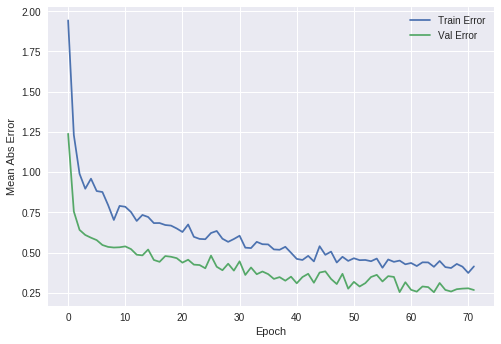

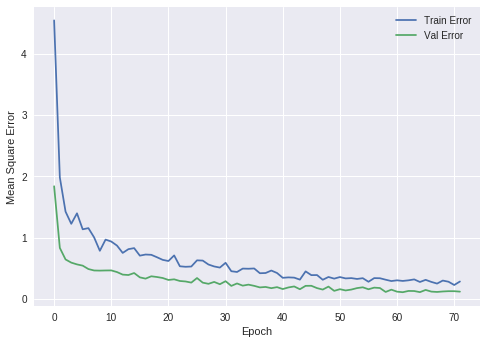

In [41]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,3])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,5])

plot_history(final_history)

**Assess model performance on test data**

(0, 7.170694161296703)

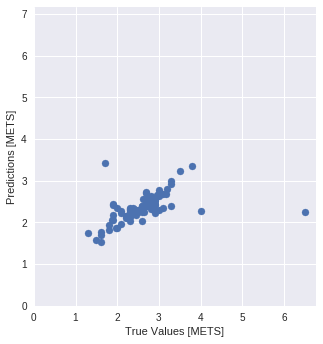

In [43]:
test_predictions = final_model.predict(final_test_X).flatten()

plt.scatter(final_test_y, test_predictions)
plt.xlabel('True Values [METS]')
plt.ylabel('Predictions [METS]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

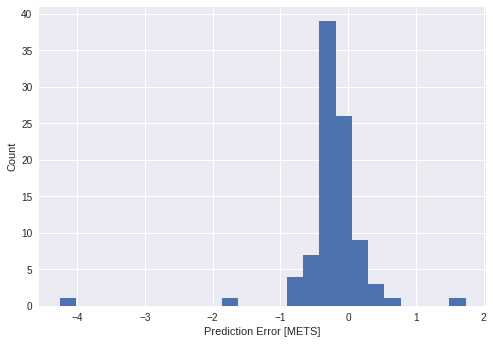

In [45]:
error = test_predictions - final_test_y
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error [METS]')
_ = plt.ylabel('Count')